In [1]:
import pandas
import seaborn
import matplotlib.pyplot as pyplot
import sklearn.model_selection as model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree, metrics
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
base_dataframe = pandas.DataFrame(
    {"data": newsgroups["data"],
     "target": newsgroups["target"],
     "target_name": [newsgroups["target_names"][int(x)] for x in newsgroups["target"]]
     }
)
base_dataframe.head()

,data,target,target_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


**1)**

    Loading and exploring data (Total points: 25)
    Use the following code to load the dataset (this will require an internet connection to download the
    dataset, the first time it is run).

(a) (5 points) How many instances (examples) are in the dataset?

In [3]:
base_dataframe["data"].count()


18846

(b) (5 points) How many and which classes does the dataset define?

In [4]:
len(base_dataframe["target_name"].unique())

20

(c) (8 points) Make a plot showing the class distribution in the dataset.

<AxesSubplot:xlabel='count', ylabel='target_name'>

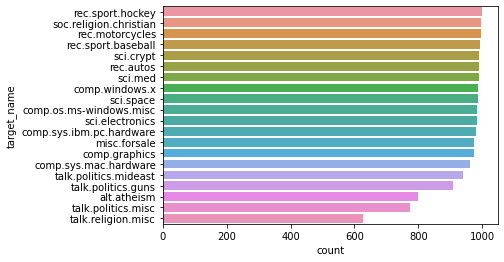

In [5]:
seaborn.countplot(data=base_dataframe, y="target_name",
                  order=base_dataframe["target_name"].value_counts().index)


(d) (7 points) Look at a few of the samples. Is there anything in the examples that might cause a classifier to overfit to the training data? How can you fix this? Change the code above accordingly!

Answer: It seems likely that the headers, footers and quotes would be unnecessary bloat in the training data, therefore we remove those values while pre-processing the data.


**2.**
    Splitting the data into training and test data (Total points: 14)

(a) (7 points) Split the data into a training and test set using 20% of the data for testing. (train -
test split might be useful.)

In [6]:
training, testing = model_selection.train_test_split(base_dataframe, test_size=0.2)

(b) (7 points) Make a plot to check that the class distributions in the test set is similar to the
distribution in the whole data set.

<AxesSubplot:xlabel='count', ylabel='target_name'>

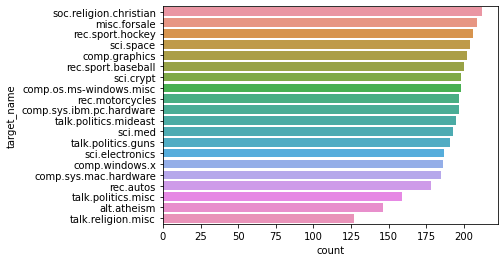

In [7]:
seaborn.countplot(data=testing, y=testing["target_name"],
                  order=testing["target_name"].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='target_name'>

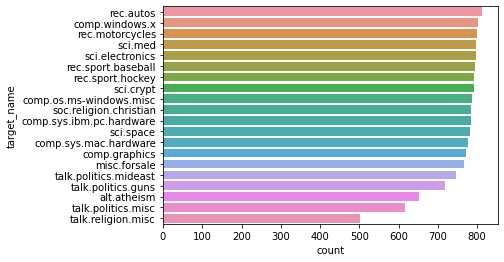

In [8]:
seaborn.countplot(data=training,y=training["target_name"],
                  order=training["target_name"].value_counts().index)

**3.**
Feature Extraction (Total points: 11)
The data we are dealing with is basically unstructured text. In order to train a classifier we need to
extract features from the data to be used as the attributes of the samples. Scikit-learn provides us
with some simple feature extraction for text. To start with we can use a simple Bag of Words representation, where each text is represented by a vector of integers, each one counting the occurrences
of specific words in the text.

(a) (6 points) How many attributes do we get from this feature extraction? Do you think this is a
good number? Why (not)?

In [9]:
vectorizer = CountVectorizer()
all_wordbag = vectorizer.fit_transform(base_dataframe["data"])
len(vectorizer.vocabulary_)

134410

Attributes in this grouping include simple short words that have no indication of newsgroup categories as well as numerious words that have spelling mistakes ore are completely unique in other ways. These words do nothing to categorize the data in the proper classes and as such should be removed.

(b) (5 points) Change the parameters of CountVectorizer to exclude words appearing in more than
half the instances and words appearing in less than 3 instances. How many attributes do you
get after that change?

In [10]:
vectorizer = CountVectorizer(max_df=0.5, min_df=3)
all_wordbag = vectorizer.fit_transform(base_dataframe["data"])
len(vectorizer.vocabulary_)

35984

**4.**
Training a Decision Tree (Total points: 25)

(a) (8 points) Use scikit-learn’s DecisionTreeClassifier to learn a decision tree from the training
data.

In [11]:
# In order to have the total word pool size the same, 
# we send a wordbag of all the data into the train_test splitter
training_x_wordbag, test_x_wordbag, training_y, test_y = \
model_selection.train_test_split(all_wordbag, base_dataframe["target_name"], test_size=0.2)
decision_tree_classifier = tree.DecisionTreeClassifier()
decision_tree_classifier.fit(X=training_x_wordbag, y=training_y) 

DecisionTreeClassifier()

(b) (4 points) How many nodes does that tree have?

In [12]:
decision_tree_classifier.tree_.node_count

9561

(c) (4 points) What is the accuracy of the tree on the training set?

In [13]:
metrics.accuracy_score(training_y, decision_tree_classifier.predict(training_x_wordbag))

0.9732687715574423

(d) (4 points) What is the accuracy of the tree on the test set?

In [14]:
metrics.accuracy_score(test_y, decision_tree_classifier.predict(test_x_wordbag))

0.4724137931034483

(e) (5 points) What do these numbers tell you about overfitting/underfitting of the model? <br> <br>
We are seeing a moderately high amount of errors in the test data and a very low error rate in the training data, which makes us suspect that the decision tree is overfitted

**5.**
Feature Selection / Hyperparameters (Total points: 25)
There are multiple methods for selecting good features. For this exercise, we can use a simple
univariate method that selects the features with the highest correlation with the class label:

In [15]:
feature_selector = SelectKBest(chi2, k=10)
training_bag = feature_selector.fit_transform(training_x_wordbag, training_y)
testing_bag = feature_selector.fit_transform(test_x_wordbag, test_y)


(a) (10 points) Add the feature selection to your code with k = 10 and report on the accuracy of
the decision tree on both training and test set. Is the tree overfitting / underfitting?

In [16]:
k_best_tree = tree.DecisionTreeClassifier().fit(X=training_bag, y=training_y)

In [17]:
metrics.accuracy_score(training_y, k_best_tree.predict(training_bag))


0.11183337755372778

In [18]:
metrics.accuracy_score(test_y, k_best_tree.predict(testing_bag))


0.07400530503978779

We are seeing a severe amount of underfitting, which is not really surprising since we're decreasing our
features from around 35.000 down to just 10

(b) (8 points) This method introduces one hyper-parameter into the machine learning method (the
number of features to select (k)). The choice of k has an influence in the accuracy of the trained
decision tree and we should aim to find a good value for k. One idea to find a good value for k
would be to repeatedly select features (with different k), train decision trees using these features
and test the trees on the test set to see for which value of k we get the best performance. Is is
a good idea? Why / why not?

(c) (7 points) Suppose we used the method from the previous question, but tested the trees on the
training set instead of the test set. What would likely be the result of this? Why?

In [20]:
# Code we used to test different values of k
for k in range(1000, 35984, 1000):
    feature_selector = SelectKBest(chi2, k=k)
    training_bag = feature_selector.fit_transform(training_x_wordbag, training_y)
    testing_bag = feature_selector.fit_transform(test_x_wordbag, test_y)
    new_tree_too = tree.DecisionTreeClassifier().fit(X=training_bag, y=training_y)

    metrics.accuracy_score(training_y, new_tree_too.predict(training_bag))

    metrics.accuracy_score(test_y, new_tree_too.predict(testing_bag))


Trying to find a good accuracy by changing the k is a slow and fruitless endeavour.
After having tested many values of k for both the training and data set we have come to the conclusion that it is not very effective to filter out so many features. Even though we leave the "top 10" scoring features, the accuracy of our predictions plummets. This is most likely due to the importance of a large dataset of words in order to clearly define which newsgroup each email belongs to.
